Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data


In [1]:
import pathlib

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Upgrad/CNN-Assignment'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

Mounted at /content/gdrive


### Importing all the important libraries

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [8]:
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

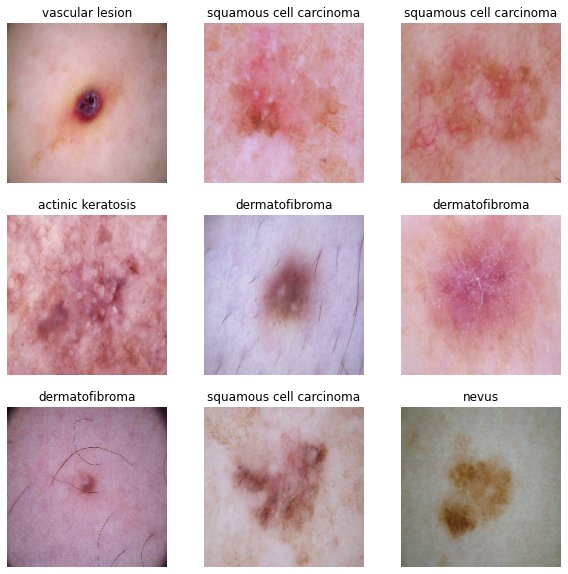

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [12]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.add(Flatten())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 61s 76ms/step - loss: 8.3416 - accuracy: 0.1046 - val_loss: 8.3865 - val_accuracy: 0.1050
Epoch 2/20
281/281 [==============================] - 11s 40ms/step - loss: 8.3329 - accuracy: 0.1046 - val_loss: 8.3865 - val_accuracy: 0.0921
Epoch 3/20
281/281 [==============================] - 11s 40ms/step - loss: 8.3329 - accuracy: 0.1022 - val_loss: 8.3865 - val_accuracy: 0.0921
Epoch 4/20
281/281 [==============================] - 11s 40ms/step - loss: 8.3329 - accuracy: 0.1065 - val_loss: 8.3865 - val_accuracy: 0.0921
Epoch 5/20
281/281 [==============================] - 12s 41ms/step - loss: 8.3329 - accuracy: 0.1016 - val_loss: 8.3865 - val_accuracy: 0.0921
Epoch 6/20
281/281 [==============================] - 11s 40ms/step - loss: 8.3329 - accuracy: 0.1025 - val_loss: 8.3865 - val_accuracy: 0.0921
Epoch 7/20
281/281 [==============================] - 11s 40ms/step - loss: 8.3329 - accuracy: 0.1012 - val_loss: 8.3865 - val_accuracy:

### Visualizing training results

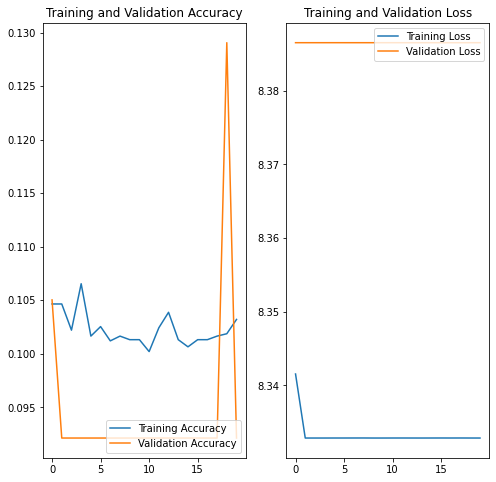

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Deciding if model overfits or underfits

In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

71/71 [==============================] - 1s 17ms/step - loss: 8.3865 - accuracy: 0.0921
Accuracy:  0.10086743533611298
Validation Accuracy:  0.09212283045053482
Loss:  8.332867622375488
Validation Loss 8.386496543884277


Thus we can clearly that model Overfit and we need to chose right data augumentation strategy


### Write your findings here

Here we trained the model with optimizer adams and epochs 30 .As we can see , till 6-7 epochs training and validation accuracy both increase . But after that training accuracy keeps on increasing to 80% whereas validation accuracy keeps fluctuating at 50% . Which means has begun to overfit .

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
# choose an appropriate data augumentation strategy. 

data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

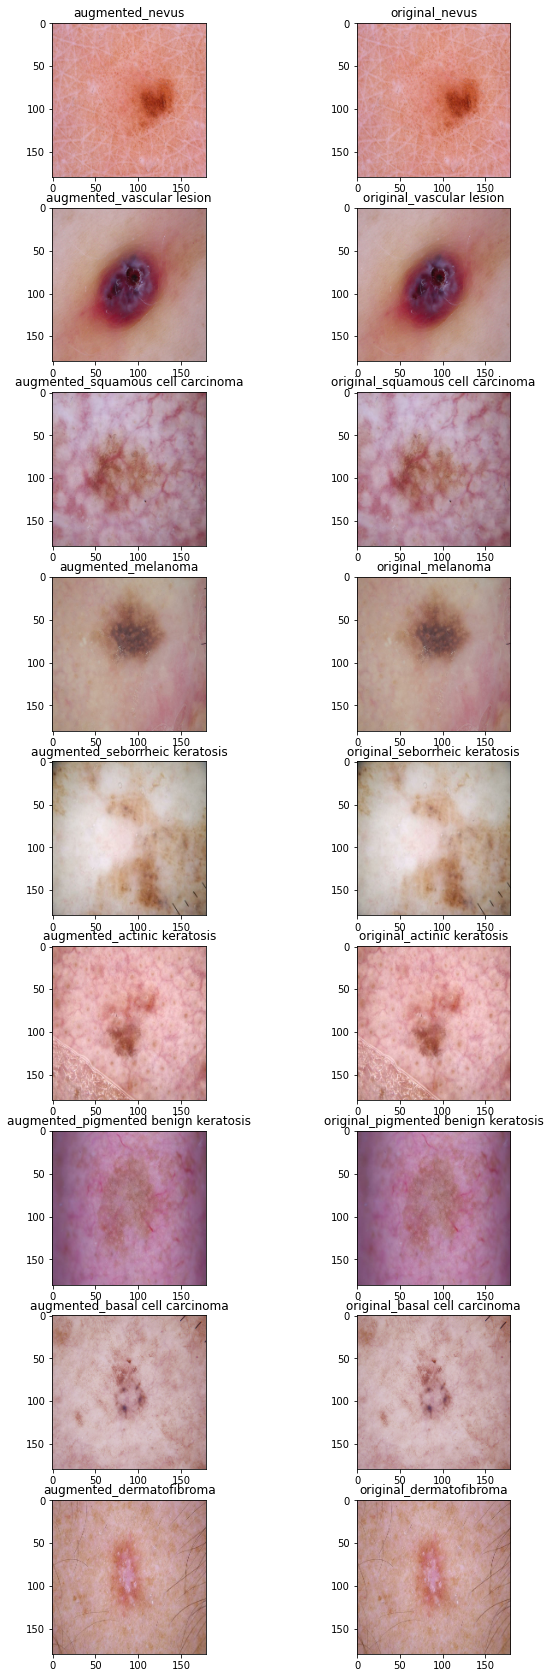

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
    # print(images," | ",labels)
      # print(images.shape)
      # print(images[0].shape)
      # plt.figure(figsize=(20,20))
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
        
  else:
    break


### Create the model, compile and train the model

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# model = Sequential([
#                     data_aug,
#                     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
#                     #first conv 2d layer
#                     Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
#                     #maxpooling layer
#                     MaxPool2D(pool_size = (2, 2)),
#                     #droput regularisation
#                     Dropout(0.25),
#                     Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
#                     #maxpooling layer
#                     MaxPool2D(pool_size = (2, 2)),
#                     #droput regularisation
#                     Dropout(0.25),
#                     Flatten(),
#                     Dense(128,activation='relu'),
#                     Dense(len(class_names))
# ])

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.add(Flatten())


### Compiling the model

In [21]:
## Your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 43, 43, 64)       

### Training the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 13s 44ms/step - loss: 2.1860 - accuracy: 0.1697 - val_loss: 2.2389 - val_accuracy: 0.1331
Epoch 2/20
281/281 [==============================] - 13s 47ms/step - loss: 2.2426 - accuracy: 0.1293 - val_loss: 2.2389 - val_accuracy: 0.1331
Epoch 3/20
281/281 [==============================] - 12s 42ms/step - loss: 2.2425 - accuracy: 0.1294 - val_loss: 2.2389 - val_accuracy: 0.1331
Epoch 4/20
281/281 [==============================] - 12s 42ms/step - loss: 2.2426 - accuracy: 0.1293 - val_loss: 2.2389 - val_accuracy: 0.1331
Epoch 5/20
281/281 [==============================] - 12s 43ms/step - loss: 2.2420 - accuracy: 0.1299 - val_loss: 2.2438 - val_accuracy: 0.1282
Epoch 6/20
281/281 [==============================] - 12s 42ms/step - loss: 2.2441 - accuracy: 0.1278 - val_loss: 2.2438 - val_accuracy: 0.1282
Epoch 7/20
281/281 [==============================] - 12s 42ms/step - loss: 2.2441 - accuracy: 0.1279 - val_loss: 2.2438 - val_accuracy:

### Visualizing the results

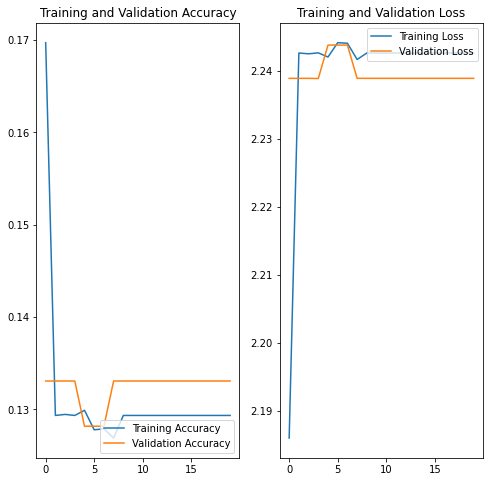

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We can see that after addition of Agumentation layers we were able to reduce the model's overfitting . However in this case the model is not able to generalise well . We tried out different set of optmizers sgd , adagrad , adams which gave models that had low Training and Validation accuracy. The accuracy figures were between 45-55% both for training and validation . But now the model has begun to overfit.

### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


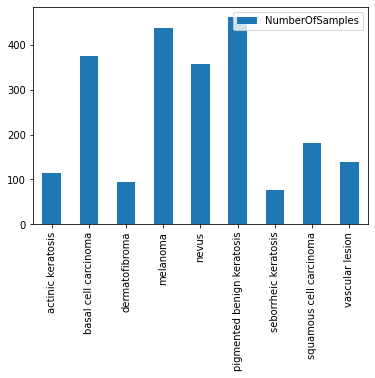

In [25]:
class_df.plot.bar()
plt.show()

#### Write your findings here: 
#### - Which class has the least number of samples?
 seborrheic keratosis(77)
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis	(462)


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import Augmentor

In [28]:
path_to_training_dataset = '/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE3E0E4850>: 100%|██████████| 500/500 [00:22<00:00, 22.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE3E66A410>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE3E03ED10>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFE3214D090>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7EFE3E092A90>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE3E66A410>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFE41A70710>: 100%|██████████| 500/500 [00:47<00:00, 10.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE418E6790>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFEBE69F190>: 100%|██████████| 500/500 [00:19<00:00, 25.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0032538.jpg_1e449720-b119-43f7-8c44-dac66bca8a98.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0032715.jpg_80fe97d5-3662-413e-ad99-b823002fdb78.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0025924.jpg_9b891613-cb2d-43f5-b913-39354ae77003.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0031719.jpg_17075ca2-4453-420a-b88e-e92c9338e616.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0033608.jpg_4cb900a5-a5f3-40eb-8537-ad75b302d112.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0025599.jpg_82a0486c-6eb0-4d46-bcb9-620ba2c3c163.jpg',
 '/content/gdrive/MyDrive/Up

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [34]:
df2['Label'].value_counts()

vascular lesion               1500
squamous cell carcinoma       1500
seborrheic keratosis          1500
pigmented benign keratosis    1500
actinic keratosis             1500
melanoma                      1500
dermatofibroma                1500
basal cell carcinoma          1500
nevus                         1500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
data_dir_train="/content/gdrive/MyDrive/Upgrad/CNN-Assignment/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### Create your model (make sure to include normalization)

In [38]:
# model = Sequential([
#                     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
#                     Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
#                     MaxPool2D(pool_size = (2, 2)),
#                     Dropout(0.40),
#                     Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
#                     MaxPool2D(pool_size = (2, 2)),
#                     Dropout(0.40),
#                     Flatten(),
#                     Dense(128,activation='relu'),
#                     Dense(len(class_names))
# ])
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),padding = 'Same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.40))
model.add(layers.Conv2D(64,kernel_size=(3,3),padding = 'Same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.40))
model.add(layers.Conv2D(128,kernel_size=(3,3),padding = 'Same',activation='relu'))
model.add(layers.Dropout(0.40))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.40))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.40))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.add(Flatten())

#### Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

#### Train your model

In [40]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
394/394 [==============================] - 78s 186ms/step - loss: 2.2470 - accuracy: 0.1248 - val_loss: 2.2566 - val_accuracy: 0.1153
Epoch 2/50
394/394 [==============================] - 70s 174ms/step - loss: 2.2469 - accuracy: 0.1251 - val_loss: 2.2566 - val_accuracy: 0.1153
Epoch 3/50
394/394 [==============================] - 73s 181ms/step - loss: 2.2469 - accuracy: 0.1251 - val_loss: 2.2566 - val_accuracy: 0.1153
Epoch 4/50
394/394 [==============================] - 68s 170ms/step - loss: 2.2611 - accuracy: 0.1108 - val_loss: 2.2722 - val_accuracy: 0.0998
Epoch 5/50
394/394 [==============================] - 68s 170ms/step - loss: 2.2718 - accuracy: 0.1001 - val_loss: 2.2722 - val_accuracy: 0.0998
Epoch 6/50
394/394 [==============================] - 72s 179ms/step - loss: 2.2716 - accuracy: 0.1004 - val_loss: 2.2722 - val_accuracy: 0.0998
Epoch 7/50
394/394 [==============================] - 68s 170ms/step - loss: 2.2717 - accuracy: 0.1002 - val_loss: 2.2722 - val_ac

####  Visualize the model results

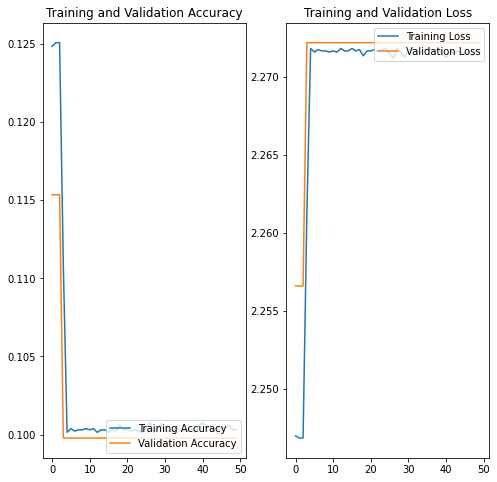

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


By adding augmented images which inturn helped in handling class imbalance , we mitigated/addressed the problem of overfitting . Out of all the models the performance was decent for the model with Adam's optimizer . The model had a train accuracy of ~90% while the validation accuracy was about ~80% . This model learns rapidly (increase in training and validation accuracy)for the first 20 epochs , but after this the learning becomes slow .